In [1]:
# Install the necessary libraries
!pip install torch torchvision torchaudio
!pip install nibabel
!pip install tqdm
!pip install scikit-learn
!pip install matplotlib
!pip install nilearn


[notice] A new release of pip is available: 23.3.1 -> 25.0
[notice] To update, run: python -m pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 22.3 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.4.0
    Uninstalling typing_extensions-4.4.0:
      Successfully uninstalled typing_extensions-4.4.0

[notice] A new release of pip is available: 23.3.1 -> 25.0
[notice] To update, run: python -m pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 1.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 9.0 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.1 -> 25.0
[notice] To update, run: python -m pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 93.6 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━

In [ ]:
!kaggle datasets download awsaf49/brats20-dataset-training-validation

In [ ]:
import zipfile
with zipfile.ZipFile('brats20-dataset-training-validation.zip', 'r') as zip_ref:
    zip_ref.extractall('/workspace')

In [2]:

import os
import glob
import nibabel as nib
import numpy as np
print("NumPy version:", np.__version__)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from torch.utils.data import random_split

# Monkey-patch the RandomSampler to avoid calling .numpy() if necessary
from torch.utils.data.sampler import RandomSampler

original_iter = RandomSampler.__iter__

def new_iter(self):
    # Instead of calling .numpy(), call .tolist()
    n = len(self.data_source)
    generator = self.generator
    if generator is None:
        yield from map(int, torch.randperm(n).tolist())
    else:
        yield from map(int, torch.randperm(n, generator=generator).tolist())

RandomSampler.__iter__ = new_iter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device available: ",device)
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

NumPy version: 1.24.1
device available:  cuda
NVIDIA GeForce RTX 4090


In [3]:
# ---------------------------
# Custom Dataset for BraTS
# ---------------------------
class BraTSDataset(Dataset):
    def __init__(self, images_dir, masks_dir, scaler, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.scaler = scaler
        self.transform = transform

        # Loading image and mask paths
        self.images = sorted(glob.glob(os.path.join(images_dir, '*')))
        self.masks = sorted(glob.glob(os.path.join(masks_dir, '*')))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_file = self.images[idx]
        mask_file = self.masks[idx]

        # Load image using np.load or nibabel
        if os.path.splitext(image_file)[1] == '.npy':
            image = np.load(image_file)
        else:
            image = nib.load(image_file).get_fdata()

        # Load mask using np.load or nibabel
        if os.path.splitext(mask_file)[1] == '.npy':
            mask = np.load(mask_file)
        else:
            mask = nib.load(mask_file).get_fdata()

        # Normalize the image using the provided scaler.
        orig_shape = image.shape
        if len(orig_shape) == 4:
            # Flatten spatial dimensions and scale each channel
            image = self.scaler.fit_transform(image.reshape(-1, orig_shape[-1])).reshape(orig_shape)
        else:
            image = self.scaler.fit_transform(image.reshape(-1, 1)).reshape(orig_shape)

        # Process the mask:
        # 1. Convert to uint8 and reassign label 4 to 3.
        mask = mask.astype(np.uint8)
        mask[mask == 4] = 3

        # 2. If the mask is one-hot encoded, convert to class indices.
        if mask.ndim == 4 and mask.shape[-1] == 4:
            mask = np.argmax(mask, axis=-1)

        # 3. If the image has more than 3 channels, choose the first 3 channels.
        if image.ndim == 4 and image.shape[-1] >= 3:
            image = np.stack([image[..., 0], image[..., 1], image[..., 2]], axis=-1)

        # Apply any additional transforms if provided.
        if self.transform:
            image, mask = self.transform(image, mask)

        # Convert to torch tensors.
        # Permute image from (H, W, D, C) to (C, H, W, D)
        if image.ndim == 4:
            image_tensor = torch.tensor(image, dtype=torch.float32).permute(3, 0, 1, 2)
        else:
            image_tensor = torch.tensor(image, dtype=torch.float32)
        mask_tensor = torch.tensor(mask, dtype=torch.long)

        return image_tensor, mask_tensor

Brain affine:
 [[ -1.  -0.  -0.   0.]
 [ -0.  -1.  -0. 239.]
 [  0.   0.   1.   0.]
 [  0.   0.   0.   1.]]
Segmentation affine:
 [[ -1.  -0.  -0.   0.]
 [ -0.  -1.  -0. 239.]
 [  0.   0.   1.   0.]
 [  0.   0.   0.   1.]]
Original image shape: (240, 240, 155)
Predicted segmentation shape: (240, 240, 155)


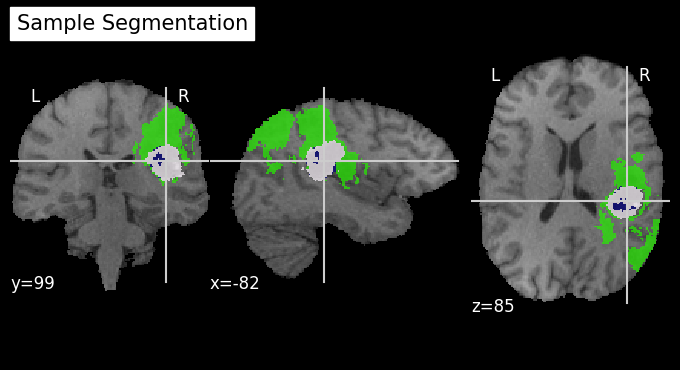

In [4]:
#PLOTING SAMPLE SEGMENTATIONS

from nilearn import plotting,image

brain_img = image.load_img('/workspace/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_010/BraTS20_Training_010_t1.nii')
seg_img = image.load_img('/workspace/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_010/BraTS20_Training_010_seg.nii')
# Check if affines match
print("Brain affine:\n", brain_img.affine)
print("Segmentation affine:\n", seg_img.affine)
print("Original image shape:", brain_img.shape)
print("Predicted segmentation shape:", seg_img.shape)

# Resample segmentation to match the brain image if affines differ
if not (brain_img.affine == seg_img.affine).all():
    seg_img = image.resample_to_img(seg_img, brain_img)
# Plot the segmentation over the brain image
plotting.plot_roi(seg_img, bg_img=brain_img, title="Sample Segmentation")
plotting.show()


In [5]:
# -------------------------------------------------
# Define Residual Recurrent Blocks for 3D U-Net
# -------------------------------------------------

class RecurrentBlock3D(nn.Module):
    """
    A recurrent convolutional block for 3D data.
    It applies an initial convolution followed by a number of recurrent steps
    where each recurrent step adds its result to the current output.
    """
    def __init__(self, channels, kernel_size=3, recur_num=2):
        super(RecurrentBlock3D, self).__init__()
        padding = kernel_size // 2  # keep spatial dimensions
        self.recur_num = recur_num

        self.initial_conv = nn.Conv3d(channels, channels, kernel_size, padding=padding)
        self.initial_bn   = nn.BatchNorm3d(channels)
        self.relu         = nn.ReLU(inplace=True)

        # Shared convolution for recurrent steps
        self.conv = nn.Conv3d(channels, channels, kernel_size, padding=padding)
        self.bn   = nn.BatchNorm3d(channels)

    def forward(self, x):
        out = self.initial_conv(x)
        out = self.initial_bn(out)
        out = self.relu(out)
        for _ in range(self.recur_num):
            out_res = self.conv(out)
            out_res = self.bn(out_res)
            out_res = self.relu(out_res)
            out = out + out_res  # residual addition
        return out
        
class ResidualRecurrentBlock3D(nn.Module):
    """
    A residual recurrent block that uses a shortcut connection.
    It first creates a shortcut using a 1x1 convolution, then applies two
    recurrent blocks sequentially and adds the shortcut back.
    """
    def __init__(self, in_channels, filters, kernel_size=3, recur_num=2):
        super(ResidualRecurrentBlock3D, self).__init__()
        self.shortcut = nn.Conv3d(in_channels, filters, kernel_size=1, padding=0)
        self.rrb1 = RecurrentBlock3D(filters, kernel_size, recur_num)
        self.rrb2 = RecurrentBlock3D(filters, kernel_size, recur_num)

    def forward(self, x):
        shortcut = self.shortcut(x)
        out = self.rrb1(shortcut)
        out = self.rrb2(out)
        return out + shortcut
        


class AttentionBlock3D(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        """
        Parameters:
          F_g: Number of channels in the gating signal (from the decoder).
          F_l: Number of channels in the encoder feature map (skip connection).
          F_int: Number of intermediate channels.
        """
        super(AttentionBlock3D, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv3d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv3d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv3d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        # g: gating signal (from the decoder, e.g., upsampled feature map)
        # x: encoder feature map from the skip connection
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        # Multiply the skip connection by the attention coefficients
        return x * psi


In [8]:
# ------------------------------
# Define the R2-UNet 3D Model  with Attention Gates
# ------------------------------


class R2UNet3DWithAttention(nn.Module):
    """
    A Residual Recurrent 3D U-Net (R2-UNet) architecture with Attention Gates
    on the skip connections.
    """
    def __init__(self, in_channels, num_classes, recur_num=2):
        super(R2UNet3DWithAttention, self).__init__()
        # Encoder dropout layers
        self.dropout1 = nn.Dropout3d(0.1)
        self.dropout2 = nn.Dropout3d(0.1)
        self.dropout3 = nn.Dropout3d(0.2)
        self.dropout4 = nn.Dropout3d(0.2)
        self.dropout5 = nn.Dropout3d(0.3)

        # Encoder
        self.c1 = ResidualRecurrentBlock3D(in_channels, 16, recur_num=recur_num)
        self.pool1 = nn.MaxPool3d(2)

        self.c2 = ResidualRecurrentBlock3D(16, 32, recur_num=recur_num)
        self.pool2 = nn.MaxPool3d(2)

        self.c3 = ResidualRecurrentBlock3D(32, 64, recur_num=recur_num)
        self.pool3 = nn.MaxPool3d(2)

        self.c4 = ResidualRecurrentBlock3D(64, 128, recur_num=recur_num)
        self.pool4 = nn.MaxPool3d(2)

        # Bridge
        self.c5 = ResidualRecurrentBlock3D(128, 256, recur_num=recur_num)

        # Decoder
        self.up6 = nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2)
        # Attention gate for skip connection from c4: channels 128 (both gating and skip) -> intermediate channels = 64
        self.att4 = AttentionBlock3D(F_g=128, F_l=128, F_int=64)
        self.c6 = ResidualRecurrentBlock3D(256, 128, recur_num=recur_num)

        self.up7 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        self.att3 = AttentionBlock3D(F_g=64, F_l=64, F_int=32)
        self.c7 = ResidualRecurrentBlock3D(128, 64, recur_num=recur_num)

        self.up8 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2)
        self.att2 = AttentionBlock3D(F_g=32, F_l=32, F_int=16)
        self.c8 = ResidualRecurrentBlock3D(64, 32, recur_num=recur_num)

        self.up9 = nn.ConvTranspose3d(32, 16, kernel_size=2, stride=2)
        self.att1 = AttentionBlock3D(F_g=16, F_l=16, F_int=8)
        self.c9 = ResidualRecurrentBlock3D(32, 16, recur_num=recur_num)

        self.out_conv = nn.Conv3d(16, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        c1 = self.c1(x)
        p1 = self.pool1(c1)
        p1 = self.dropout1(p1)

        c2 = self.c2(p1)
        p2 = self.pool2(c2)
        p2 = self.dropout2(p2)

        c3 = self.c3(p2)
        p3 = self.pool3(c3)
        p3 = self.dropout3(p3)

        c4 = self.c4(p3)
        p4 = self.pool4(c4)
        p4 = self.dropout4(p4)

        c5 = self.c5(p4)
        c5 = self.dropout5(c5)

        # Decoder with Attention Gates
        u6 = self.up6(c5)  # Upsample from bottleneck: shape (B,128,...)
        # Apply attention gate on c4 using u6 as gating signal
        c4_att = self.att4(g=u6, x=c4)
        u6 = torch.cat([u6, c4_att], dim=1)
        c6 = self.c6(u6)
        c6 = self.dropout4(c6)

        u7 = self.up7(c6)
        c3_att = self.att3(g=u7, x=c3)
        u7 = torch.cat([u7, c3_att], dim=1)
        c7 = self.c7(u7)
        c7 = self.dropout3(c7)

        u8 = self.up8(c7)
        c2_att = self.att2(g=u8, x=c2)
        u8 = torch.cat([u8, c2_att], dim=1)
        c8 = self.c8(u8)
        c8 = self.dropout2(c8)

        u9 = self.up9(c8)
        c1_att = self.att1(g=u9, x=c1)
        u9 = torch.cat([u9, c1_att], dim=1)
        c9 = self.c9(u9)
        c9 = self.dropout1(c9)

        outputs = self.out_conv(c9)
        # Note: Do not apply softmax here if using CrossEntropyLoss.
        return outputs


In [9]:
# ------------------------------
# Create DataLoader and Training
# ------------------------------
scaler = MinMaxScaler()

train_img_dir = "/workspace/BraTS2020_TrainingData/input_data_128/train/images/"
train_mask_dir = "/workspace/BraTS2020_TrainingData/input_data_128/train/masks/"
val_img_dir = "/workspace/BraTS2020_TrainingData/input_data_128/val/images/"
val_mask_dir = "/workspace/BraTS2020_TrainingData/input_data_128/val/masks/"

# Create the datasets (assuming training data already has 4 modalities per sample)
train_dataset = BraTSDataset(train_img_dir, train_mask_dir, scaler)
val_dataset = BraTSDataset(val_img_dir, val_mask_dir, scaler)

batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
import torch
model = R2UNet3DWithAttention(in_channels=3, num_classes=4, recur_num=2).to(device)

# Define Loss Function, Optimizer, and Scheduler
class_weights = torch.tensor([0.1, 0.3, 0.3, 0.3], device=device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Metrics
def calculate_iou(preds, labels, num_classes=4, threshold=0.5):
    smooth = 1e-6  # To avoid division by zero
    preds = torch.argmax(preds, dim=1)

    iou_per_class = []
    for cls in range(num_classes):
        pred_cls = (preds == cls).float()
        label_cls = (labels == cls).float()

        intersection = (pred_cls * label_cls).sum()
        union = pred_cls.sum() + label_cls.sum() - intersection

        iou = (intersection + smooth) / (union + smooth)
        iou_per_class.append(iou.item())

    return sum(iou_per_class) / num_classes  # Average IoU across classes


num_epochs = 50
# Training Loop
for epoch in range(num_epochs):
    model.train()
    running_loss, running_corrects, train_iou = 0.0, 0, 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)  # Outputs shape: [B, C, H, W, D]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Update training loss
        running_loss += loss.item()

        # Accuracy calculation
        preds = torch.argmax(outputs, dim=1)
        running_corrects += torch.sum(preds == labels.data)


        # Compute IoU
        train_iou += calculate_iou(outputs, labels)
    
    train_loss = running_loss / len(train_loader)
    train_acc = float(running_corrects) / (len(train_loader.dataset) * labels.shape[1] * labels.shape[2] * labels.shape[3])
    train_iou /= len(train_loader)
    # Validation Phase
    model.eval()
    val_loss, val_correct,  val_iou = 0.0, 0, 0.0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)

            # Validation Loss
            v_loss = criterion(val_outputs, val_labels)
            val_loss += v_loss.item()

            # Validation Accuracy
            val_preds = torch.argmax(val_outputs, dim=1)
            val_correct += (val_preds == val_labels).sum().item()

            # Validation IoU
            val_iou +=calculate_iou(val_outputs, val_labels)
            # val_iou += iou_metric(val_preds, val_labels).item()

    
    val_loss /= len(val_loader)
    val_acc = float(val_correct) / (len(val_loader.dataset) * labels.shape[1] * labels.
                                    shape[2] * labels.shape[3])
    val_iou /= len(val_loader)

    # Adjust Learning Rate Based on Validation Loss
    scheduler.step(val_loss)

    # Print Epoch Metrics
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train IoU: {train_iou:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val IoU: {val_iou:.4f}\n")
    
# Save the model’s state dictionary after training
torch.save(model.state_dict(), 'r2_unet3d_model_epoch_50_attention.pth')
print("Model saved!")

Epoch [1/50]
Train Loss: 1.0191, Train Acc: 0.7235, Train IoU: 0.2551
Val Loss: 0.6569, Val Acc: 0.9589, Val IoU: 0.3053

Epoch [2/50]
Train Loss: 0.4062, Train Acc: 0.9556, Train IoU: 0.3508
Val Loss: 0.3640, Val Acc: 0.9604, Val IoU: 0.3068

Epoch [3/50]
Train Loss: 0.2748, Train Acc: 0.9574, Train IoU: 0.3515
Val Loss: 0.2853, Val Acc: 0.9614, Val IoU: 0.3308

Epoch [4/50]
Train Loss: 0.2439, Train Acc: 0.9585, Train IoU: 0.3728
Val Loss: 0.2684, Val Acc: 0.9631, Val IoU: 0.3646

Epoch [5/50]
Train Loss: 0.2162, Train Acc: 0.9630, Train IoU: 0.4029
Val Loss: 0.2576, Val Acc: 0.9662, Val IoU: 0.3701

Epoch [6/50]
Train Loss: 0.2065, Train Acc: 0.9634, Train IoU: 0.4280
Val Loss: 0.2686, Val Acc: 0.9632, Val IoU: 0.4023

Epoch [7/50]
Train Loss: 0.1915, Train Acc: 0.9668, Train IoU: 0.4559
Val Loss: 0.2546, Val Acc: 0.9653, Val IoU: 0.3973

Epoch [8/50]
Train Loss: 0.1840, Train Acc: 0.9675, Train IoU: 0.4723
Val Loss: 0.2401, Val Acc: 0.9648, Val IoU: 0.4407

Epoch [9/50]
Train Loss:

In [34]:
# ------------------------------
# Inference on New Data
# ------------------------------
def load_nii(file_path):
    """Load a NIfTI file and return the image data and its affine."""
    img = nib.load(file_path)
    data = img.get_fdata()
    return data, img.affine

def normalize_image(image, scaler=None):
    """Normalize the image using MinMaxScaler."""
    if scaler is None:
        scaler = MinMaxScaler()
    orig_shape = image.shape
    if len(orig_shape) == 3:
        norm = scaler.fit_transform(image.reshape(-1, 1)).reshape(orig_shape)
    elif len(orig_shape) == 4:
        norm = scaler.fit_transform(image.reshape(-1, orig_shape[-1])).reshape(orig_shape)
    else:
        raise ValueError("Unsupported image dimensions")
    return norm

def save_prediction_as_nii(prediction, affine, output_path):
    """Save the predicted segmentation as a NIfTI file."""
    nii = nib.Nifti1Image(prediction.astype(np.uint16), affine)
    nib.save(nii, output_path)
    print(f"Prediction saved to {output_path}")


# Reinitialize and load the trained model for inference
model = R2UNet3DWithAttention(in_channels=3, num_classes=4, recur_num=2).to(device)

model.load_state_dict(torch.load('/workspace/r2_unet3d_model_epoch_50_attention.pth', map_location=device))
model.eval()

# Define file paths for new input data (adjust these paths as needed)
flair_path = '/workspace/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_020/BraTS20_Training_020_flair.nii'
t1ce_path  = '/workspace/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_020/BraTS20_Training_020_t1ce.nii'
t2_path    = '/workspace/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_020/BraTS20_Training_020_t2.nii'

# Load images and get affine
flair_img, affine = load_nii(flair_path)
t1ce_img, _    = load_nii(t1ce_path)
t2_img, _      = load_nii(t2_path)

# Normalize each image modality
scaler = MinMaxScaler()
flair_norm  = normalize_image(flair_img, scaler=scaler)
t1ce_norm   = normalize_image(t1ce_img, scaler=MinMaxScaler())
t2_norm     = normalize_image(t2_img, scaler=MinMaxScaler())

# Crop the images to the required size (e.g., 128x128x128)
flair_cropped  = flair_norm[56:184, 56:184, 13:141]
t1ce_cropped   = t1ce_norm[56:184, 56:184, 13:141]
t2_cropped     = t2_norm[56:184, 56:184, 13:141]

# Stack the three modalities in the channel dimension and prepare the input tensor
input_image = np.stack([flair_cropped, t1ce_cropped, t2_cropped], axis=-1)
input_image = np.transpose(input_image, (3, 0, 1, 2))  # (channels, H, W, D)
input_tensor = torch.tensor(input_image, dtype=torch.float32).unsqueeze(0).to(device)  # add batch dimension




# Run inference
with torch.no_grad():
    output = model(input_tensor)  # output shape: (1, 4, H, W, D)
    pred = torch.argmax(output, dim=1)  # shape: (1, H, W, D)
    pred_np = pred.cpu().numpy().squeeze()  # convert to NumPy array
    
# Create an empty segmentation volume of the original shape
full_segmentation = np.zeros(flair_img.shape, dtype=pred_np.dtype)  # Shape: (240, 240, 155)

# Define the cropping coordinates used during preprocessing
x_start, x_end = 56, 184
y_start, y_end = 56, 184
z_start, z_end = 13, 141

# Insert the predicted segmentation back into the original space
full_segmentation[x_start:x_end, y_start:y_end, z_start:z_end] = pred_np

# Save the prediction as a NIfTI file
output_path = '/workspace/predicted_segmentation_020_attention_50.nii'
save_prediction_as_nii(full_segmentation, affine, output_path)



Prediction saved to /workspace/predicted_segmentation_020_attention_50.nii


Brain affine:
 [[ -1.  -0.  -0.   0.]
 [ -0.  -1.  -0. 239.]
 [  0.   0.   1.   0.]
 [  0.   0.   0.   1.]]
Segmentation affine:
 [[ -1.  -0.  -0.   0.]
 [ -0.  -1.  -0. 239.]
 [  0.   0.   1.   0.]
 [  0.   0.   0.   1.]]
Original image shape: (240, 240, 155)
Predicted segmentation shape: (240, 240, 155)


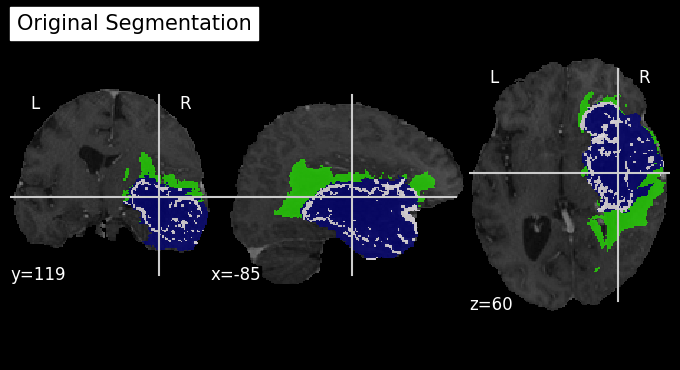

In [35]:

from nilearn import plotting,image

brain_img = image.load_img('/workspace/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_020/BraTS20_Training_020_t1ce.nii')
seg_img = image.load_img('/workspace/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_020/BraTS20_Training_020_seg.nii')
# Check if affines match
print("Brain affine:\n", brain_img.affine)
print("Segmentation affine:\n", seg_img.affine)
print("Original image shape:", brain_img.shape)
print("Predicted segmentation shape:", seg_img.shape)
# Resample segmentation to match the brain image if affines differ
if not (brain_img.affine == seg_img.affine).all():
    seg_img = image.resample_to_img(seg_img, brain_img)
# Plot the segmentation over the brain image
plotting.plot_roi(seg_img, bg_img=brain_img, title="Original Segmentation")
plotting.show()

Brain affine:
 [[ -1.  -0.  -0.   0.]
 [ -0.  -1.  -0. 239.]
 [  0.   0.   1.   0.]
 [  0.   0.   0.   1.]]
Segmentation affine:
 [[ -1.  -0.  -0.   0.]
 [ -0.  -1.  -0. 239.]
 [  0.   0.   1.   0.]
 [  0.   0.   0.   1.]]
Original image shape: (240, 240, 155)
Predicted segmentation shape: (240, 240, 155)


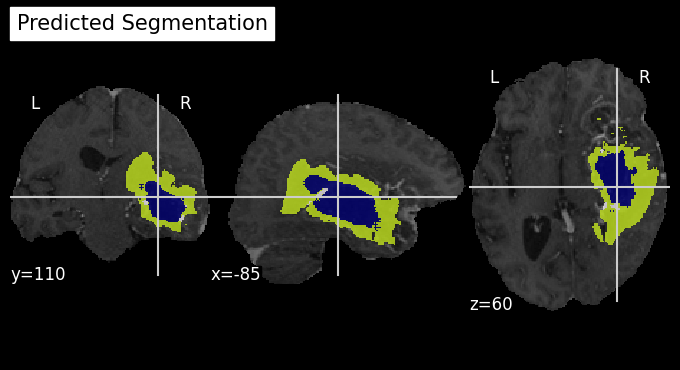

In [36]:
from nilearn import plotting,image

brain_img = image.load_img('/workspace/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_020/BraTS20_Training_020_t1ce.nii')
seg_img = image.load_img('/workspace/predicted_segmentation_020_attention_50.nii')
# Check if affines match
print("Brain affine:\n", brain_img.affine)
print("Segmentation affine:\n", seg_img.affine)
print("Original image shape:", brain_img.shape)
print("Predicted segmentation shape:", seg_img.shape)
# Resample segmentation to match the brain image if affines differ
if not (brain_img.affine == seg_img.affine).all():
    seg_img = image.resample_to_img(seg_img, brain_img)
# Plot the segmentation over the brain image
plotting.plot_roi(seg_img, bg_img=brain_img, title="Predicted Segmentation")
plotting.show()

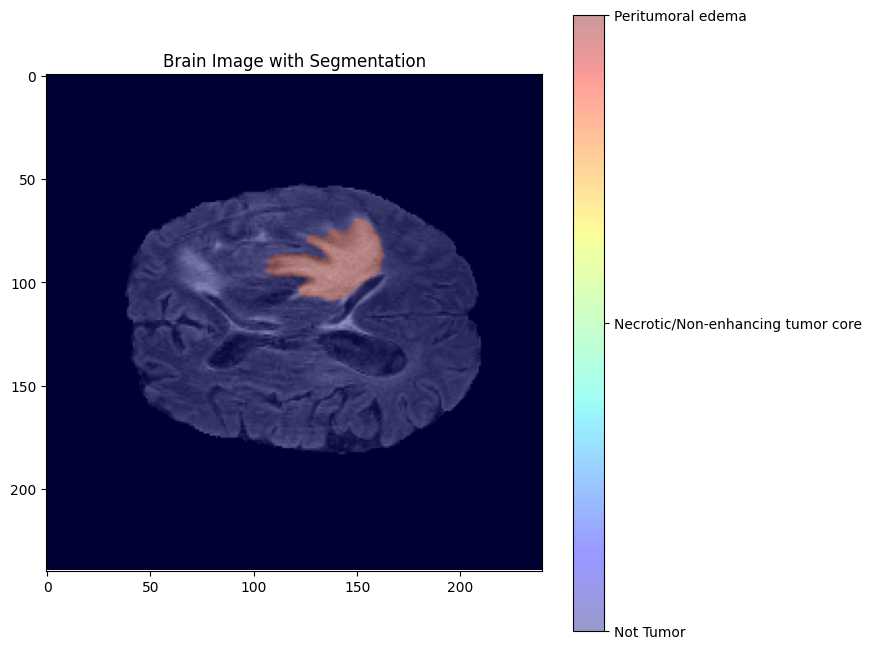

In [37]:

label_dict = {
    0: "Not Tumor",
    1: "Necrotic/Non-enhancing tumor core",
    2: "Peritumoral edema",
    3: "Enhancing tumor"
}
# Function to map the predicted segmentation to label names
def map_labels_to_names(segmentation, label_dict):
    labeled_segmentation = np.vectorize(label_dict.get)(segmentation)
    return labeled_segmentation

# Apply the label mapping to your predicted segmentation
labeled_pred = map_labels_to_names(pred_np, label_dict)

# Create an empty volume matching the original brain image size
full_segmentation = np.zeros(flair_img.shape, dtype=pred_np.dtype)  # Shape: (240, 240, 155)

# Insert the predicted segmentation back into its correct position
x_start, x_end = 56, 184
y_start, y_end = 56, 184
z_start, z_end = 13, 141

full_segmentation[x_start:x_end, y_start:y_end, z_start:z_end] = pred_np

import matplotlib.pyplot as plt

# Select a slice to visualize (middle slice along Z-axis)
slice_idx = flair_img.shape[2] // 2

# Plot the brain image with the restored segmentation overlay
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(flair_img[:, :, slice_idx], cmap='gray')  # Original brain image
seg_overlay = ax.imshow(full_segmentation[:, :, slice_idx], cmap='jet', alpha=0.4)  # Restored segmentation overlay

# Add color bar with labels
cbar = plt.colorbar(seg_overlay, ax=ax, ticks=[0, 1, 2, 3])
cbar.ax.set_yticklabels([label_dict[i] for i in range(4)])

ax.set_title("Brain Image with Segmentation")
plt.show()



In [17]:

#END